# Can player age and experience predict a player's total hours spent in game?
Group 005-1 - Emily Ung, Owen Hochwald, Mariah Fang

# Introduction

In collaboration with a research group at UBC led by Frank Wood, this project aims to use data to make predictions about how people play video games, specifically, Minecraft. As the researchers want to recruit players who will contribute large amounts of data, the question we will address is whether the age and experience level of a player can predict their total hours spent in game. The data provided by the research group consists of two datasets: players and sessions. For the purpose of this project, we will be using the players dataset.

The players dataset lists all individual players, as well as information for each individual. It has 196 observations, meaning there are 196 individual players. The 7 variables are as follows:

- experience (character variable): A variable describing the player's past experience with the game. Players are categorized from Beginner to Pro levels of experience. 
- subscribe (logical variable): A variable indicating whether or not the player is subscribed to a game-related newsletter.
- hashedEmail (character variable): A variable that records the individual encrypted email address of the player. 
- played_hours (double variable): The total amount of hours the player has spent in game.
- name (character variable): The player's name.
- gender (character variable): The player's gender.
- Age (double variable): The player's age, in years.

To predict a player's in-game hours, we will use regression with a K-nearest neighbours approach. The predictor variables are the age and experience level of the player. We will split our data into training and testing datasets, use cross-validation to choose the k value, and then make predictions on the test data. Regression is a method in data science used to predict numeric values (in-game hours). Knn also has the advantage of not requiring the data to look a certain way or to be linear. 

Using the categories of players based on experience level (experience) and age (Age), we can predict if different types of players spend different amounts of time in game (played_hours), and thus, if they will contribute different amounts of data. 


# Methods & Results

### Results  

- **Data Preprocessing**:
  - *Cleaning Column Names*:Used janitor::clean_names() to standardize column names for easier manipulation, replacing any irregularities or spaces with underscores.

  - *Selecting Relevant Columns*: Dropped irrelevant columns and focused on 'age', 'experience', and 'played_hours' as these directly contribute to the analysis.

  - *Converting Data Types*: Transformed the 'experience' column into a categorical factor to facilitate analysis based on grouped categories.

  - *Drop Missing Values*: Removed rows with any missing data to maintain the integrity of the statistical analysis.

 - **Importing Libraries**:
      - Utilized tidyverse for data manipulation, tidymodels for modeling, and other libraries for additional functionalities.
  
- **Loading Dataset**:
      - We download the data and put it into a new GitHub repository and read the data via a raw link to guarantee reliable data retrieval for analysis.

- **Exploratory Data Analysis**:
      - Generated summary statistics to understand the central tendencies and distributions within the dataset. For instance, computed mean values for 'played_hours' and 'age', providing insights into the average behaviors and characteristics of the players.

- **Visualization Details**:

  - **Player Age vs. Played Hours**:
      - Utilized a scatter plot to visualize the relationship between player age and the number of hours played.
      - Applied a logarithmic scale to the y-axis (scale_y_log10()) to better handle wide variations in played hours, which helps in displaying the data across a broad range of values.
  - **Average Played Hours by Experience Level**:
      - Displayed using a bar chart to compare the average number of hours played across different player experience levels.
      - The visualization clearly seperates experience categories, showing that more experienced players tend to spend more time playing, which is a important for understanding user engagement based on experience.
- **Data Splitting**:  
  - Divided the dataset into an 80% training set and a 20% testing set, stratified by 'played_hours' to maintain balanced data distribution, controlled by setting the seed to 42.

- **Model Selection & Tuning**:  
  - Setup: Configured a K-Nearest Neighbors (KNN) model, standardizing 'age' through centering and scaling, using a "rectangular" weight function.
  - Tuning: Determined the optimal number of neighbors (k = 9) using cross-validation to minimize the root mean squared error (RMSE), enhancing the model's prediction accuracy.


After tuning, the KNN model was retrained using the optimized number of neighbors (k=9) for regression. This model was then applied to the testing dataset to predict played hours, and its performance was evaluated using RMSE, resulting in a value of 18.20708. This measure helps in assessing the prediction accuracy of the model relative to actual data.

- **Final Visualization**:
    - The final visualization plots the actual versus predicted hours played as a function of player age, based on the KNN model's predictions over the players' dataset. This figure, which uses points for actual data and a line for predictions, helps visualize the model's performance across several age groups and clearly shows the link between age and playing time.


### Importing Libraries

In [1]:
# loading libraries
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(repr)
library(janitor)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Loading Data

In [2]:
# loading data
players <- read_csv('https://raw.githubusercontent.com/owenHochwald/DSCI-Project-Data/refs/heads/main/players.csv')

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Preprocessing

In [3]:
# wrangling data
players_clean <- players |>
                clean_names() |>
                select(age, experience, played_hours) |>
                mutate(experience = as_factor(experience)) |>
                drop_na()
players_clean

age,experience,played_hours
<dbl>,<fct>,<dbl>
9,Pro,30.3
17,Veteran,3.8
17,Veteran,0.0
⋮,⋮,⋮
22,Veteran,0.3
17,Amateur,0.0
17,Amateur,2.3


### Summary Statistics

In [4]:
players_mean <- players_clean |>
        select(played_hours, age) |>
        map_df(mean)

players_mean

played_hours,age
<dbl>,<dbl>
5.904639,20.52062


In [5]:
summary(players_clean)

      age           experience  played_hours    
 Min.   : 8.00   Pro     :13   Min.   :  0.000  
 1st Qu.:17.00   Veteran :48   1st Qu.:  0.000  
 Median :19.00   Amateur :63   Median :  0.100  
 Mean   :20.52   Regular :35   Mean   :  5.905  
 3rd Qu.:22.00   Beginner:35   3rd Qu.:  0.600  
 Max.   :50.00                 Max.   :223.100  

### Visualizations

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


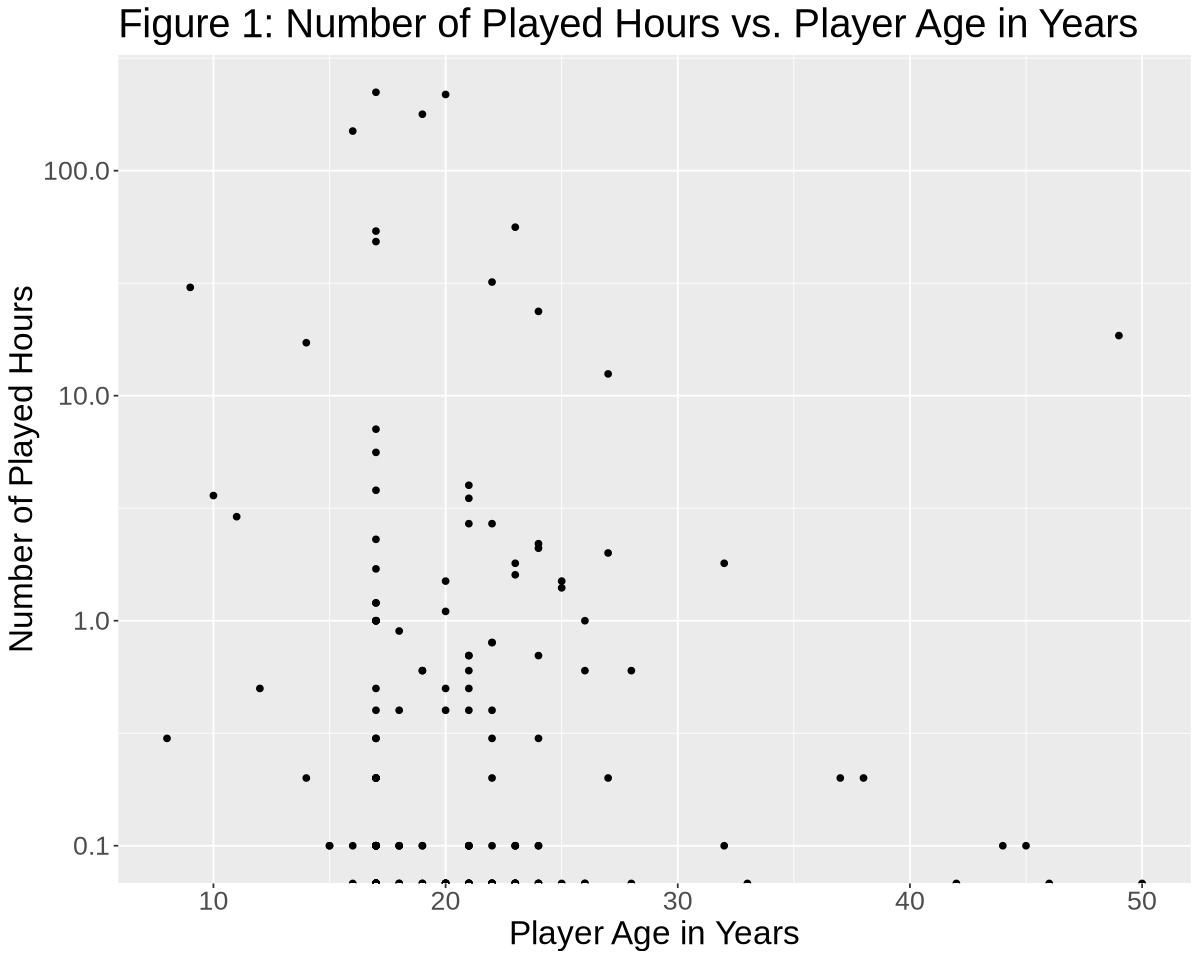

In [6]:
options(repr.plot.width=10, repr.plot.height=8)

ggplot(players_clean, aes(x=age, y=played_hours)) +
        geom_point() +
        xlab("Player Age in Years") +
        scale_y_log10() +
        ylab("Number of Played Hours") +
        theme(text=element_text(size=20)) +
        ggtitle("Figure 1: Number of Played Hours vs. Player Age in Years")

       

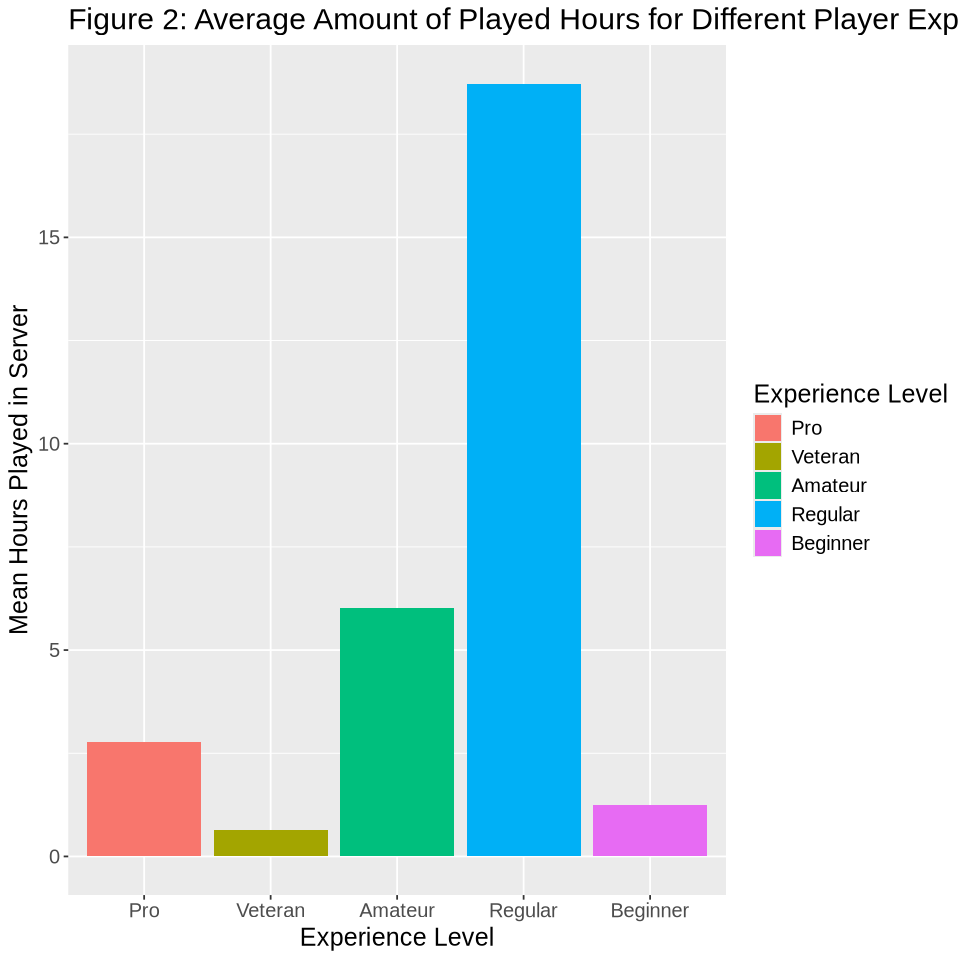

In [7]:
options(repr.plot.width=8, repr.plot.height=8)


exp_means <- players_clean |>
    group_by(experience) |>
    summarize(mean_played_hours = mean(played_hours))

exp_plot <- exp_means |>
    ggplot(aes(x = experience, y= mean_played_hours, fill=experience)) +
    geom_bar(stat = "identity") +
    xlab("Experience Level") +
    ylab("Mean Hours Played in Server") +
    ggtitle("Figure 2: Average Amount of Played Hours for Different Player Expierence Levels") +
    labs(fill="Experience Level") +
    theme(text = element_text(size=15))

exp_plot

### Creating split

In [8]:
set.seed(42)

# encoding experience into a numerical column that is zero based
players_clean <- players_clean |>
     mutate(experience_encoded = as.numeric(factor(players_clean$experience, levels = c("Amateur", "Veteran", "Pro", "Beginner", "Regular"))) - 1) |>
     select(-experience)

split <- initial_split(players_clean, prop = 0.8, strata = played_hours)
players_train <- training(split)
players_testing <- testing(split)

### Hyperparameter Tuning

Optimal number of neighbors is k = 9

In [9]:
set.seed(42)
knn_recipe <- recipe(played_hours ~., data=players_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors()) 

knn_model <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) |>
    set_engine("kknn") |>
    set_mode("regression") 

k_vals <- tibble(neighbors = seq(from=1,to=10, by=1))

val <- vfold_cv(players_train, v=5, strata=played_hours)

find_k <- workflow() |>
    add_model(knn_model) |>
    add_recipe(knn_recipe) |>
    tune_grid(resample = val, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    filter(mean == min(mean))


find_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
8,rmse,standard,28.69678,5,5.64994,Preprocessor1_Model08


### Retraining Model with new K

In [10]:
set.seed(42)

knn_model <- nearest_neighbor(weight_func="rectangular", neighbors=9) |>
    set_engine("kknn") |>
    set_mode("regression") 

knn_fit <- workflow() |>
    add_model(knn_model) |>
    add_recipe(knn_recipe) |>
    fit(data=players_train)

In [11]:
set.seed(42)

hours_summary <- knn_fit |>
  predict(players_testing) |>
  bind_cols(players_testing) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')
hours_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,18.38504


### Visualizing Analysis

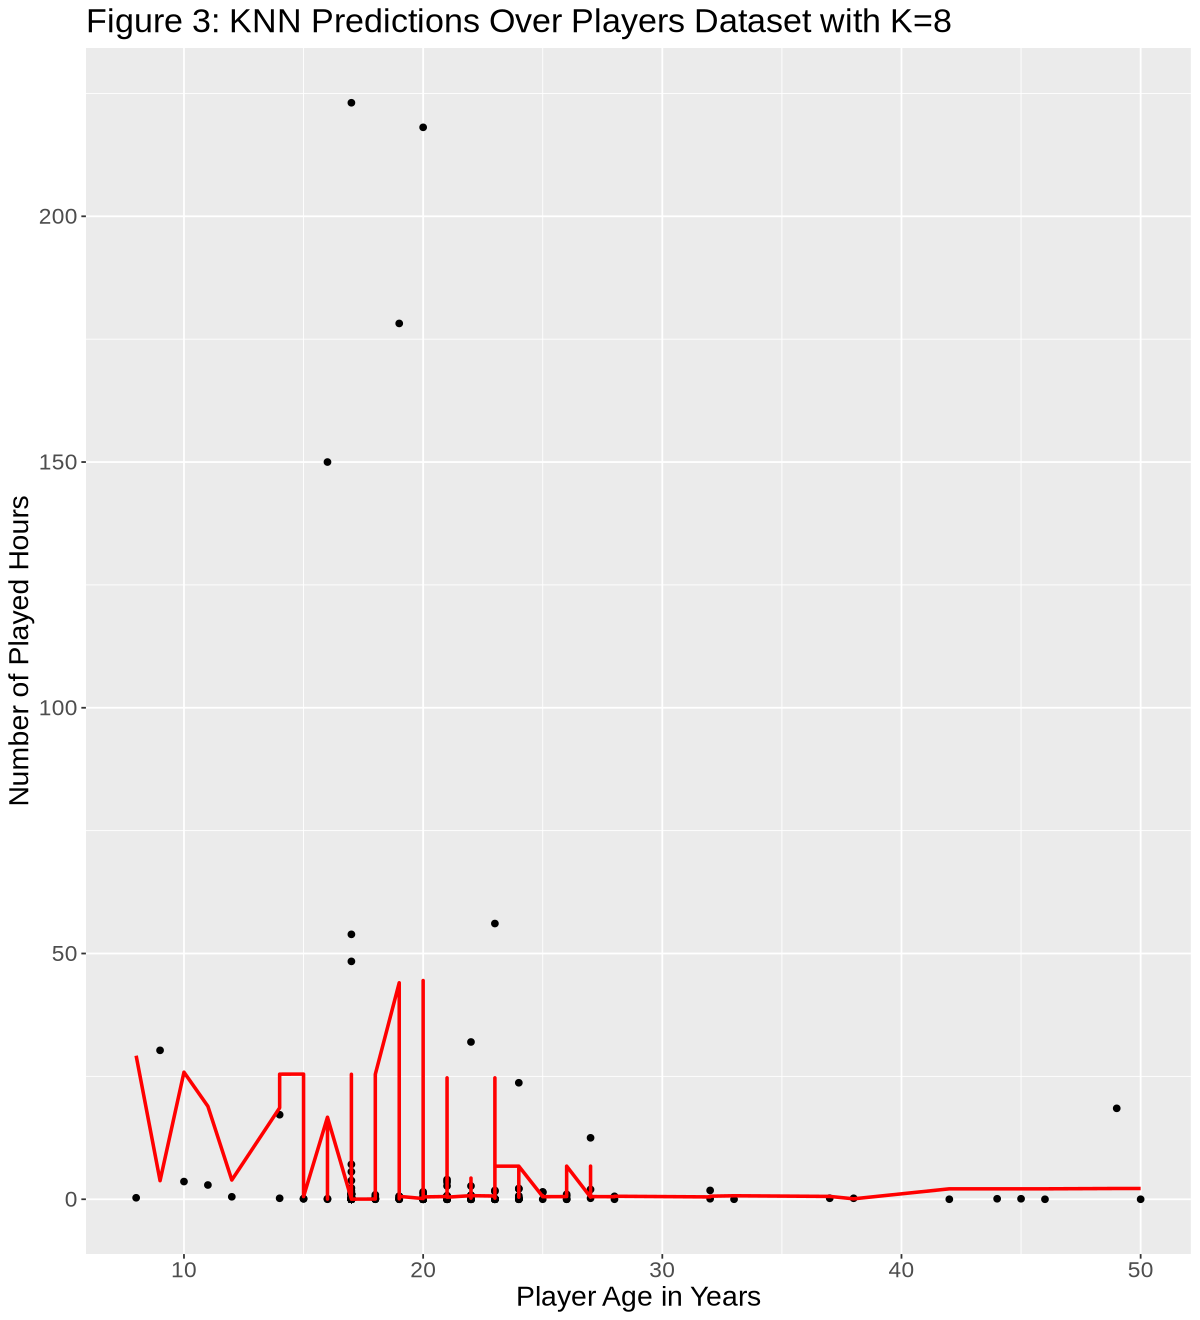

In [12]:
options(repr.plot.width=10, repr.plot.height=11)

players_preds <- knn_fit |>
  predict(players_clean) |>
  bind_cols(players_clean) 

plot_final <- ggplot(players_preds, aes(x = age, y = played_hours)) +
  geom_point() +
  geom_line(data = players_preds,
            mapping = aes(x = age, y = .pred),
            color = "red",
            linewidth = 1) +
  xlab("Player Age in Years") +
  ylab("Number of Played Hours") +
  ggtitle("Figure 3: KNN Predictions Over Players Dataset with K=8") +
  theme(text = element_text(size = 17))

plot_final

# Discussion